In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - SB02_parameters.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate orbital parameters for the SB02 stellar sample. Sample 5D gaia kinematics with covariances and
determine orbital parameters and uncertainties using a MC approach.
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning

## galpy
from galpy import orbit
from galpy import potential
from galpy import actionAngle
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis
# import ohstars.potential

In [3]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['text.usetex'] = True

# Meta
## Future Work
- Add in extra systematic error, 0.035 mas? Following Gaia, Helmi + 2018

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Preparation
## Keywords

In [4]:
# Number of samples
n_samples = 100

# Integration keywords
# t_orbit = [2,10,1,40,3,2] # Gyr

## Read Gaia Data

In [5]:
# Filename
gaia_filename = '../../data/gaia/SB02_results.vot'
# gaia_filename = '../../data/gaia/Gaia_DR2_SB02_Matched_Results.csv'

In [6]:
# gaia_dtypes = ['U20','int','float','float','float','float','float','float','float','float','float','float']
# gaia_data = np.genfromtxt(gaia_filename, comments='#', dtype=gaia_dtypes)

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab_gaia = table.Table.read(gaia_filename)
###w

n_stars = len(tab_gaia)

In [7]:
# tab_gaia

## Read RV Data

In [8]:
sb02_filename = '../../data/gaia/SB02_RV.csv'

In [9]:
tab_vrad = table.Table.read(sb02_filename, format='csv')
vrad_name = tab_vrad['star_name'].data
vrad = tab_vrad['rv'].data
vrad_err = tab_vrad['rv_err'].data

In [10]:
# tab_vrad

## Function to evaluate orbit parameters

In [11]:
 def evaluate_orbit_parameters_numerical(pot, tab, vrad, vrad_err, n_samples, star_names):
    '''evaluate_orbit_parameters_numerical:
    
    Args:
    
    Returns:
        
    '''
    n_stars = len(star_names)
    n_params = 6
    all_stats = np.zeros( ( n_stars, n_params, 3 ) )
    
    # Loop over all stars
    for i in tqdm_nb( range(n_stars) ):
        
        # Make the figure
        # fig = plt.figure( figsize=(15,8) )
        # axs = fig.subplots( nrows=2, ncols=3 )

        # Sample the data
        samples, _ = ohstars.analysis.sample_kinematics( tab[i], n_samples=n_samples )
        rv_samples = np.random.normal( vrad[i], vrad_err[i], size=n_samples )

        # Arrays to hold output parameters
        peri = np.zeros(n_samples)
        apo = np.zeros(n_samples)
        Lz = np.zeros(n_samples)
        Tr = np.zeros(n_samples)
        ecc = np.zeros(n_samples)
        zmax = np.zeros(n_samples)

        # Loop over the trials
        for j in range(n_samples):

            # Unpack the sample:
            ra, dec, par, pmra, pmdec = samples[j]
            rv = rv_samples[j]
            dist = 1/par # In kpc

            # Now declare the orbit
            o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
            
            # Output
            peri[j] = o.rperi(analytic=True, pot=pot, type='staeckel').value
            apo[j] = o.rap(analytic=True, pot=pot, type='staeckel').value
            Lz[j] = (o.vT(0)*o.R(0)).value
            Tr[j] = o.Tr(analytic=True, pot=pot, type='staeckel').value
            ecc[j] = o.e(analytic=True, pot=pot, type='staeckel')
            zmax[j] = o.zmax(analytic=True, pot=pot, type='staeckel').value

        # Arrays for statistics. Critical, order is: rperi, rapo, Lz, Tr, eccentricity, zmax
        params = np.array([peri,apo,Lz,Tr,ecc,zmax])
        
        # Loop over the parameters
        for k in range(n_params):
            
            # Get parameter and compute statistics
            this_param = params[k]
            param_median = np.median(this_param)
            param_c68p_l = np.sort(this_param)[int(0.16*n_samples)]
            param_c68p_u = np.sort(this_param)[int(0.84*n_samples)]
            
            all_stats[i,k,0] = param_median
            all_stats[i,k,1] = param_median-param_c68p_l
            all_stats[i,k,2] = param_c68p_u-param_median
        ###k
    
    # No output
    return all_stats

#def

# Determine Orbital Parameters
Use different potentials. Start with MWPotential2014 then use McMillan 2017

## MWPotential2014
Loop over each star and determine orbital parameters

In [12]:
# Evaluate
mw2014_stats = evaluate_orbit_parameters_numerical(potential.MWPotential2014, tab_gaia, 
                                                   vrad, vrad_err, 10, vrad_name)

A Jupyter Widget

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/util/bovy_coords.py:1872: RuntimeWarning: overflow encountered in sinh
  R= delta*sc.sinh(u)*sc.sin(v)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/util/bovy_coords.py:1873: RuntimeWarning: overflow encountered in cosh
  z= delta*sc.cosh(u)*sc.cos(v)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/actionAngle/actionAngleStaeckel.py:373: RuntimeWarning: invalid value encountered in add
  e= (rap-rperi)/(rap+rperi)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)




In [13]:
mw2014_stats[:,4,0]

array([0.75375717, 0.61221132, 0.88475181, 0.90631022, 0.94085221,
       0.90581833, 0.53946805, 0.51077852, 0.92274942, 0.96267136,
       0.61587872, 0.35720604, 0.46242718, 0.49417082, 0.76588596,
       0.93008257, 0.97155154, 0.78626403, 0.08509796, 0.35290414,
       0.99469145, 0.99510519, 0.98449224, 0.97403115, 0.98648602,
       0.90178419, 0.67707665, 0.96837055, 0.83906269, 0.97042134,
       0.69055753, 0.97507299, 0.91812305, 0.96560544, 0.77016271,
       0.78672879, 0.91558474, 0.66784168, 0.39298523, 0.99413515,
       0.7606727 , 0.97527406, 0.98259376, 0.31852169, 0.7802375 ,
       0.98744391,        nan, 0.94918287, 0.97558057, 0.81529312,
       0.96543023, 0.95460812, 0.87586261, 0.26319186])

# Plot interesting trends

In [14]:
# Prepare
n_params = 6
plot_names = [r'$r_{peri}$ [kpc]', r'$r_{apo}$ [kpc]', r'$L_{z}$ [kpc km s$^{-1}$]', 
              r'$T_{r}$ [Gyr]', r'eccentricity', r'$Z_{max}$ [kpc]']

## Histograms

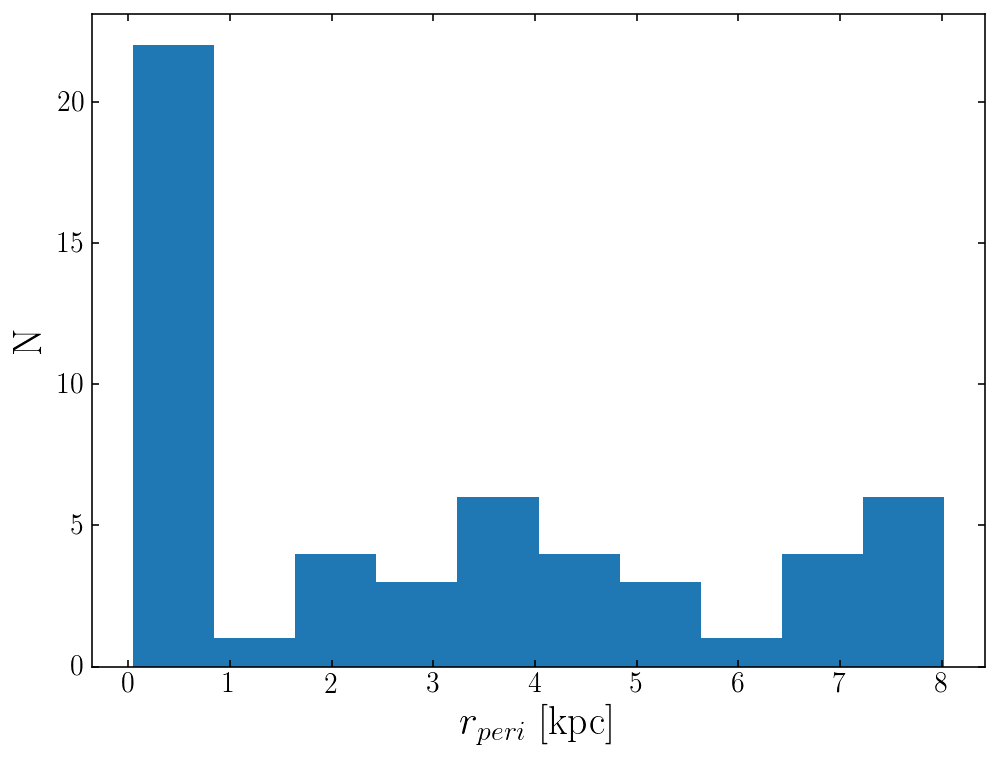

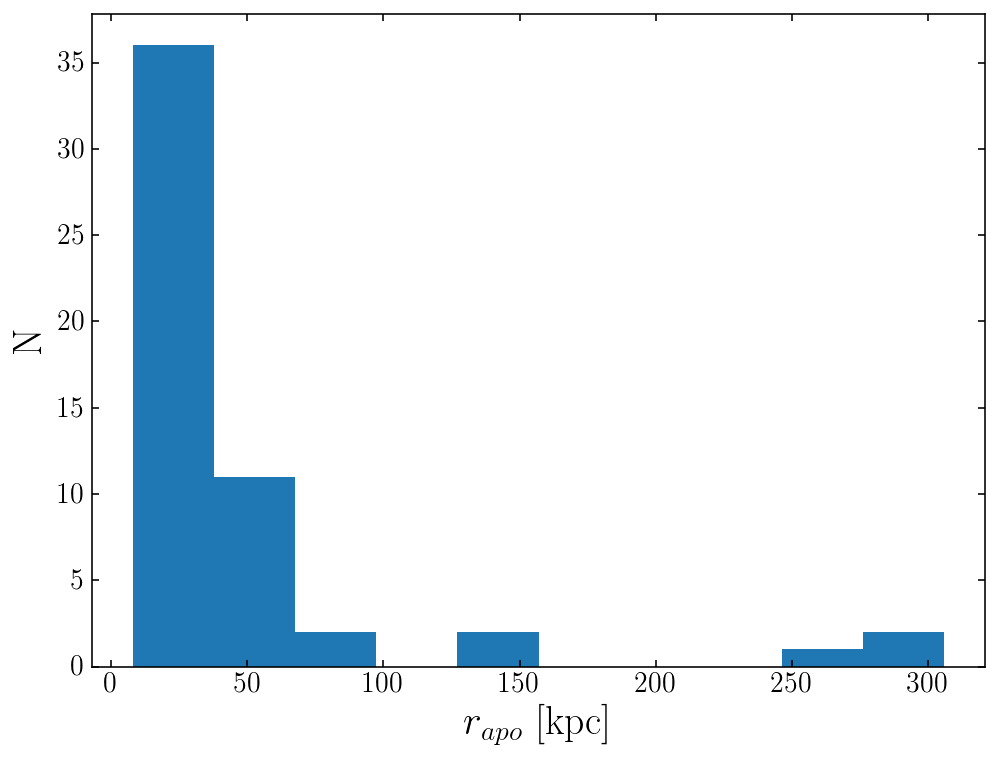

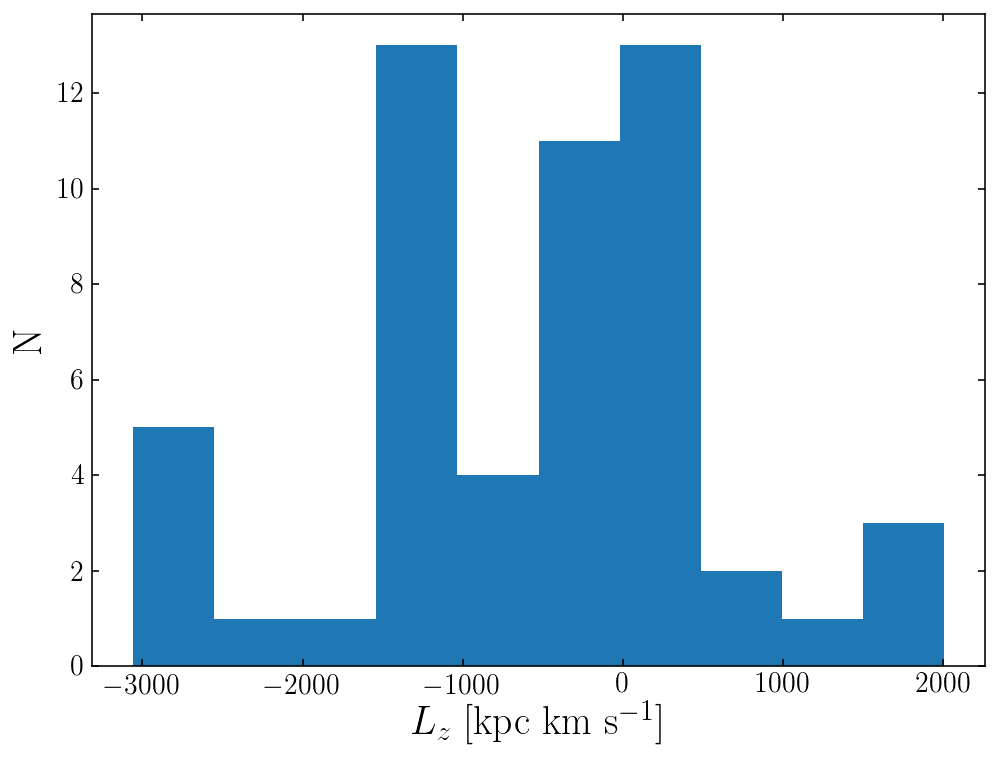

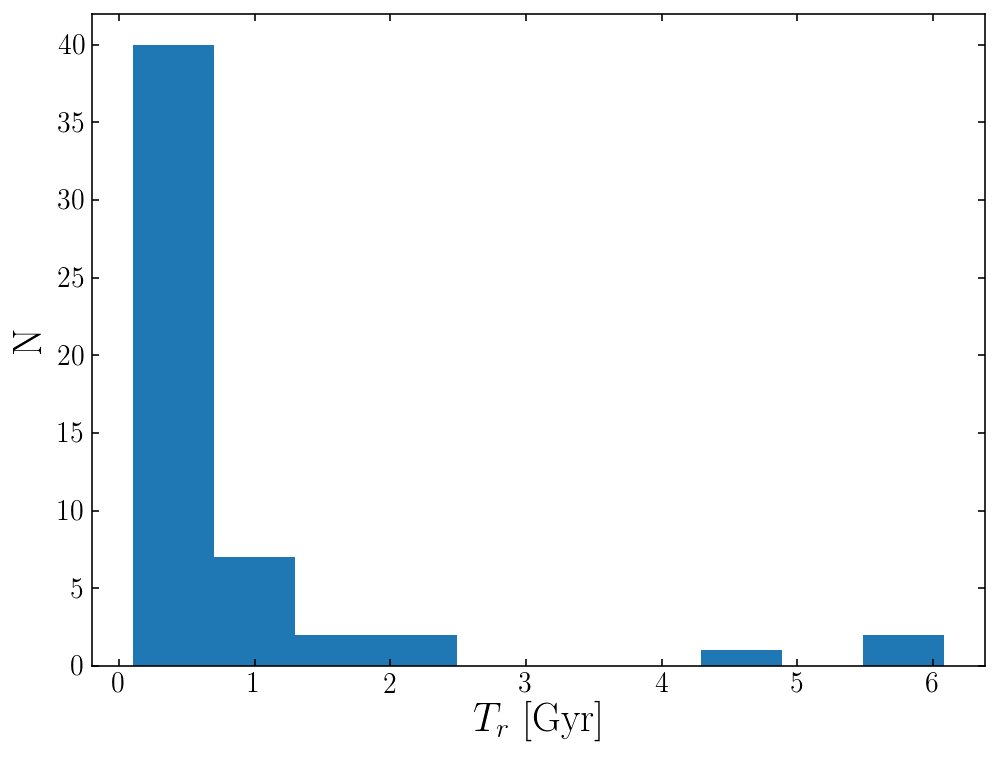

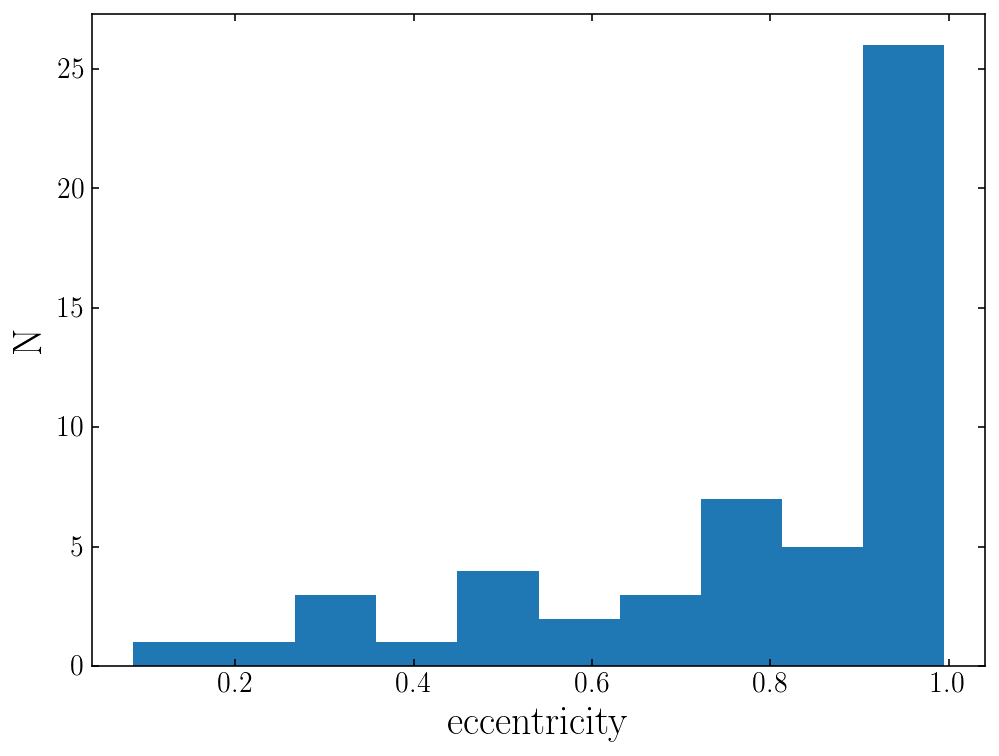

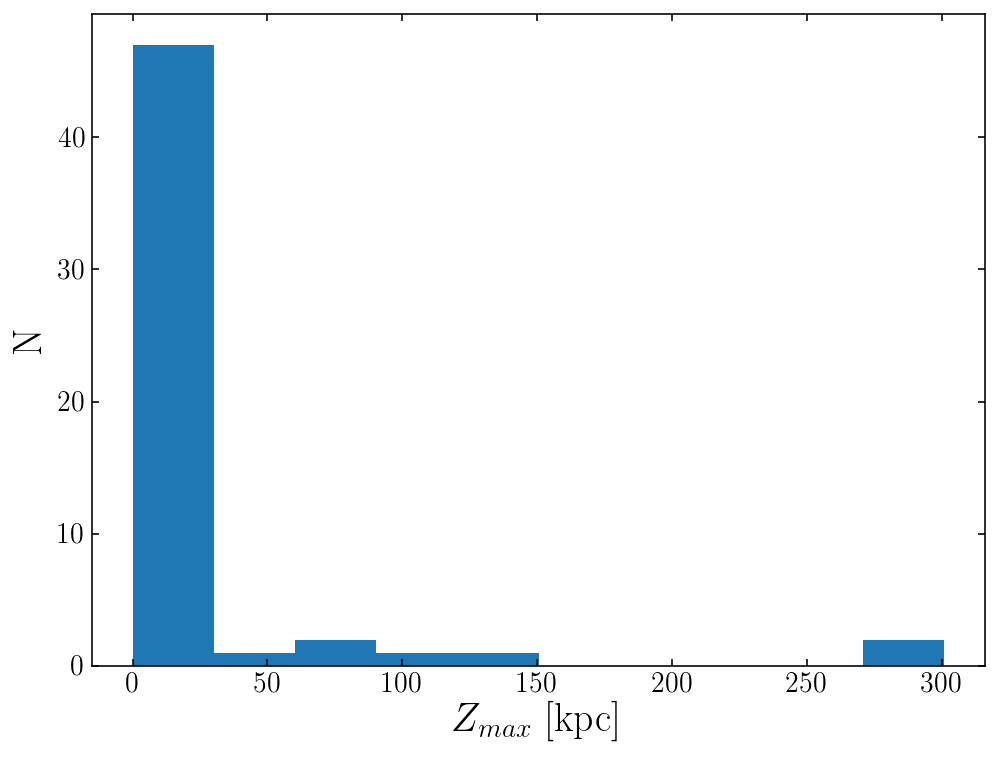

In [15]:
for i in range(n_params):
  
    fig = plt.figure( figsize=(8,6) )
    ax = fig.add_subplot(111)
    
    this_stat = mw2014_stats[:,i,0]
    
    ax.hist( this_stat[ np.isfinite(this_stat) ], bins=10 )
    
    ax.set_xlabel(plot_names[i], fontsize=20)
    ax.set_ylabel('N', fontsize=20)
    ax.tick_params( labelsize=14 )
    
    plt.show()
    
###i

# Output catalog

In [16]:
output_names = ('Name','rp','rperi_err','rapo','rapo_err','Lz','Lz_err','Tr','Tr_err','Eccen','Eccen_err')

output_dtypes = ('U10','float','float','float','float','float','float','float','float','float','float')

output_table = table.Table( [vrad_name, 
                             mw2014_stats[:,0,0], np.average([mw2014_stats[:,0,1],mw2014_stats[:,0,2]], axis=0), 
                             mw2014_stats[:,1,0], np.average([mw2014_stats[:,1,1],mw2014_stats[:,1,2]], axis=0), 
                             mw2014_stats[:,2,0], np.average([mw2014_stats[:,2,1],mw2014_stats[:,2,2]], axis=0), 
                             mw2014_stats[:,3,0], np.average([mw2014_stats[:,3,1],mw2014_stats[:,3,2]], axis=0), 
                             mw2014_stats[:,4,0], np.average([mw2014_stats[:,4,1],mw2014_stats[:,4,2]], axis=0),
                             mw2014_stats[:,5,0], np.average([mw2014_stats[:,5,1],mw2014_stats[:,5,2]], axis=0) 
                             ], names = output_names, dtype=output_dtypes
                           )
output_table.write('./SB02_orbit_parameters.FIT', overwrite=True)